In [1]:
%cd ../src

C:\Users\nozoe-tatsuya\dev\ai-ocr-ensemble\src


In [2]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

from pathlib import Path

import dataprocess as dp
import models
from args import Args

In [3]:
# デフォルト値以外のパラメータ設定
# デフォルト値はArgsの定義を参照
arg_params = {
    'epochs': 100,
    'batch_size': 512,
    'nb_classes': 17,
    'eval_interval': 5,
    # params of gMLP
    'patch_size': 4,
    'num_blocks': 30,
    'd_model': 128,
    'mlp_ratio': 6,

    'device': 'cuda',
    'log_dir': '../logs',  # logのルートディレクトリ
    'project': 'model-ensemble',  # logファイルのディレクトリ
    'model': 'stacking',
    'version': 'stack-three-models',
    'json_path': '../data/dataset_info_1.json',
}


# データセット設定ファイル
json_path = Path('../data/dataset_info_1.json')
assert json_path.is_file()

In [4]:
args = Args(**arg_params)
device = torch.device(args.device)
args, device

(Args(batch_size=512, nb_classes=17, epochs=100, ckpt_interval=20, eval_interval=5, device='cuda', log_dir='../logs', model_dir='../models', project='model-ensemble', model='stacking', version='stack-three-models', resnet_layers=18, use_se_module=False, activation='ReLU', patch_size=4, num_blocks=30, d_model=128, mlp_ratio=6, json_path='../data/dataset_info_1.json', lr=0.001, weight_decay=0.0001, optimizer='adaberief', final_lr=0.1, scheduler=None, warmup=True, warmup_epoch=5),
 device(type='cuda'))

### DataLoader

In [5]:
train_loader = dp.build_dataloader('train', args)
val_loader = dp.build_dataloader('val', args)

### backbone models

In [7]:
resnet = models.build_resnet(args)
cvt = models.build_cvt(args)
gmlp = models.build_gmlp(args)

## Inference

In [10]:
system = models.load_stacking_from_checkpoint(checkpoint_path='../models/stacking-stack-three-models-epoch=084-valid_acc_epoch=0.99.ckpt',
                                pretrained_models=[resnet, gmlp, cvt],
                                args=args)

In [11]:
results = models.infer(system, val_loader, device=device)

In [12]:
result_df, conf_matrix_df = models.build_inference(results, args, datatype='val', return_conf_matrix=True)

C:\Users\nozoe-tatsuya\dev\ai-ocr-ensemble\src\functions\conf_matrix.py:38: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  conf_matrix_df.loc[:-1, 'recall'] = recall


In [13]:
conf_matrix_df

推論ラベル                                                  \
                      0           1           2           3           4   
正解ラベル     0  395.000000    0.000000    1.000000    1.000000    0.000000   
          1    0.000000  399.000000    0.000000    0.000000    0.000000   
          2    0.000000    0.000000  398.000000    0.000000    0.000000   
          3    0.000000    0.000000    0.000000  399.000000    0.000000   
          4    0.000000    2.000000    0.000000    0.000000  394.000000   
          5    0.000000    0.000000    1.000000    0.000000    0.000000   
          6    0.000000    0.000000    0.000000    0.000000    0.000000   
          7    0.000000    0.000000    0.000000    2.000000    0.000000   
          8    0.000000    0.000000    1.000000    0.000000    0.000000   
          9    0.000000    0.000000    0.000000    0.000000    1.000000   
          *    0.000000    0.000000    0.000000    0.000000    0.000000   
          ×    0.000000    0.000000    0.000000    0.000000    0.000000   
          -    0.000000    0.000000    0.000000    0.000000    0.000000   
          ・    0.000000    0.000000    0.000000    0.000000    0.000000   
          /    1.000000    0.000000    0.000000    0.000000    0.000000   
          字    0.000000    0.000000    0.000000    0.000000    0.000000   
          ―    0.000000    0.000000    0.000000    0.000000    0.000000   
precision      0.997475    0.995012    0.992519    0.992537    0.997468   

                                                                      \
                      5           6           7           8        9   
正解ラベル     0    0.000000    2.000000    1.000000    0.000000    0.000   
          1    0.000000    0.000000    0.000000    0.000000    0.000   
          2    0.000000    0.000000    0.000000    0.000000    0.000   
          3    0.000000    0.000000    0.000000    0.000000    0.000   
          4    1.000000    0.000000    0.000000    0.000000    0.000   
          5  396.000000    1.000000    0.000000    0.000000    2.000   
          6    0.000000  401.000000    0.000000    0.000000    0.000   
          7    0.000000    0.000000  398.000000    0.000000    0.000   
          8    0.000000    0.000000    0.000000  398.000000    0.000   
          9    0.000000    0.000000    0.000000    0.000000  398.000   
          *    1.000000    0.000000    0.000000    0.000000    0.000   
          ×    0.000000    0.000000    0.000000    0.000000    0.000   
          -    0.000000    0.000000    0.000000    0.000000    0.000   
          ・    0.000000    0.000000    0.000000    0.000000    0.000   
          /    0.000000    0.000000    0.000000    1.000000    0.000   
          字    0.000000    0.000000    0.000000    0.000000    0.000   
          ―    0.000000    0.000000    0.000000    0.000000    0.000   
precision      0.994975    0.992574    0.997494    0.997494    0.995   

                                                                         \
                      *         ×      -      ・           /           字   
正解ラベル     0    0.000000    0.0000    0.0    0.0    0.000000    0.000000   
          1    0.000000    0.0000    0.0    0.0    0.000000    1.000000   
          2    0.000000    0.0000    0.0    0.0    2.000000    0.000000   
          3    0.000000    0.0000    0.0    0.0    1.000000    0.000000   
          4    0.000000    0.0000    0.0    0.0    2.000000    0.000000   
          5    0.000000    0.0000    0.0    0.0    0.000000    0.000000   
          6    0.000000    0.0000    0.0    0.0    0.000000    0.000000   
          7    0.000000    0.0000    0.0    0.0    0.000000    0.000000   
          8    0.000000    0.0000    0.0    0.0    1.000000    0.000000   
          9    0.000000    0.0000    0.0    0.0    1.000000    0.000000   
          *  395.000000    1.0000    0.0    0.0    0.000000    1.000000   
          ×    0.000000  399.0000    0.0    0.0    0.000000    1.000000   
          -    0.000000   

In [19]:
conf_matrix_df.to_excel('../results/conf_matrix_stacking_0527.xlsx')

In [14]:
result_df['correct'].mean()

0.9949109414758269

In [13]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

In [14]:
json_dict = dp.utils.load_dataset_info(json_path)
norm_params = json_dict['transform_parameters']['normalize']
mean = norm_params['mean']
std = norm_params['std']
mean, std

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [16]:
images = results['image']
pred_labels = results['pred_labels']
true_labels = results['true_labels']
confidences = results['confidence']
corrects = results['correct']

In [16]:
failed = (corrects == 0)

In [17]:
failed_images = images[failed]

In [18]:
failed_images.shape

(44, 32, 32, 3)

In [19]:
failed_grid = dp.utils.make_grid_npimage(failed_images)

In [20]:
result_df.loc[failed, :]

,x,y,pred,correct,conf_form
72,.\16\32x32_015737.png,16,*,0,0.958444
136,.\04\3-C_760169011765.jpg,4,/,0,0.812653
146,.\15\1-C_290017004171.jpg,15,4,0,0.675733
277,.\09\1-C_290186004587.jpg,9,4,0,0.539374
320,.\14\32x32_014465.png,14,0,0,0.984082
468,.\02\3-B_630237002495.jpg,2,/,0,0.900926
748,.\00\32x32_000024.png,0,6,0,0.954933
808,.\04\2-A_220262003295.jpg,4,1,0,0.982712
958,.\05\32x32_005803.png,5,/,0,0.616625
1116,.\10\1-B_620142006240.jpg,10,5,0,0.649221


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


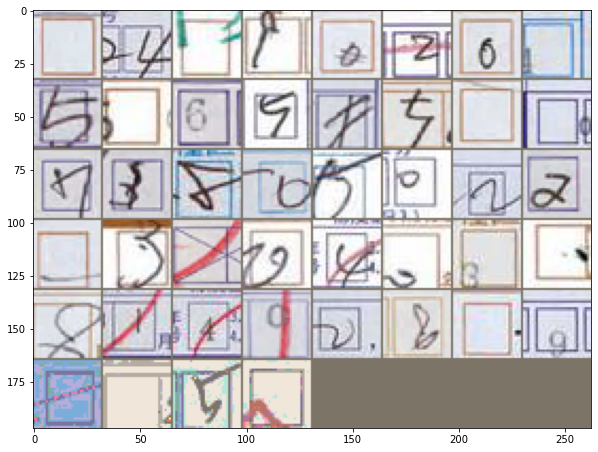

In [21]:
plt.imshow(dp.utils.denormalize(failed_grid, mean, std))

In [34]:
threshold = 0.9998
filtering = confidences > threshold

In [33]:
corrects[filtering].mean()

0.9998327759197324

In [31]:
filtering.sum() / len(corrects)

0.8724741805118994

In [18]:
c = corrects == 1

In [19]:
corrects[~filtering].shape

(1141,)

In [26]:
passed_failure_images = images[~c & filtering]

In [27]:
passed_failure_images.shape

(2, 32, 32, 3)

In [32]:
pred_labels[~c & filtering]

array([10, 15], dtype=int64)

In [31]:
true_labels[~c & filtering]

array([16, 11], dtype=int64)

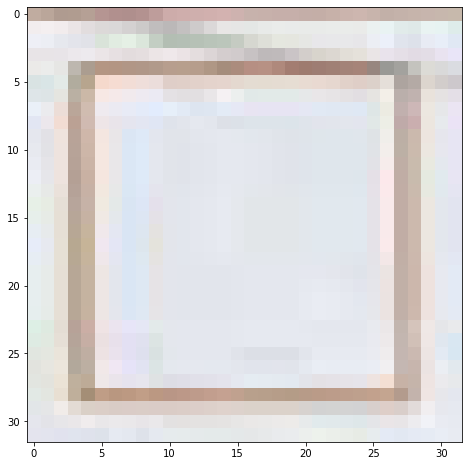

In [29]:
plt.imshow(dp.utils.denormalize(passed_failure_images[0], mean, std))

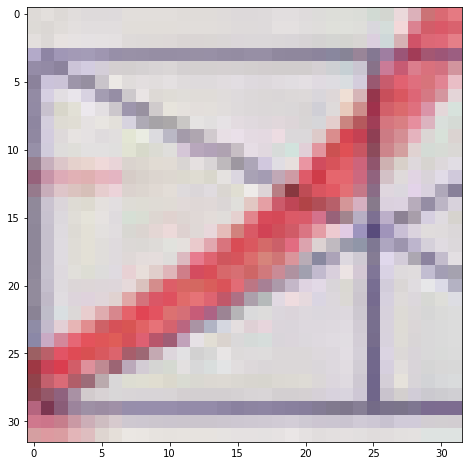

In [33]:
plt.imshow(dp.utils.denormalize(passed_failure_images[1], mean, std))

In [34]:
filterd_images = images[~filtering]

In [35]:
len(filterd_images)

458

In [38]:
filterd_images_grid = dp.utils.make_grid_npimage(filterd_images, nb_columns=20)

In [41]:
filterd_images_grid = dp.utils.denormalize(filterd_images_grid, mean, std)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


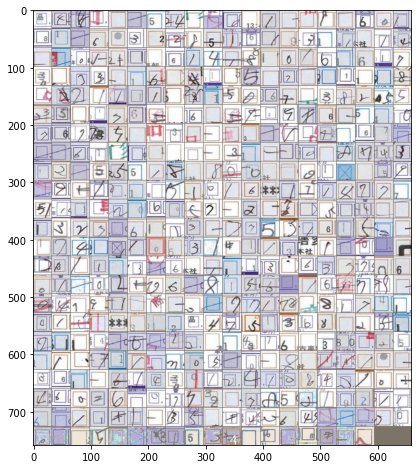

In [49]:
plt.imshow(filterd_images_grid)
plt.savefig('../results/filtered_image.png')

In [85]:
corrects.mean()

0.9934141595569526

In [86]:
corrects[filtering].mean()

0.9996786116021211

In [87]:
filtering.sum() / len(corrects)

0.9314473881155516

In [88]:
filtering.sum(), len(corrects)

(6223, 6681)

In [104]:
threshold = 0.997
filtering = confidences > threshold

In [105]:
corrects[~filtering].shape

(256,)

In [106]:
corrects.mean()

0.9934141595569526

In [107]:
corrects[filtering].mean()

0.9993774319066148

In [108]:
filtering.sum() / len(corrects)

0.9616823828768148

In [109]:
filtering.sum(), len(corrects)

(6425, 6681)